In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cmocean as cm
import pandas as pd
# pearson correlation
from scipy.stats import pearsonr
import sklearn.decomposition as skd 
import xeofs as xe

# MATLAB livescript translation

In [2]:
X=np.random.randn(480,4);
C = np.cov(X.T)
print(C)

[[ 0.83587816  0.01926815  0.01273837  0.02082681]
 [ 0.01926815  1.02710748 -0.05973229  0.01691472]
 [ 0.01273837 -0.05973229  1.01083233 -0.00624757]
 [ 0.02082681  0.01691472 -0.00624757  0.9866337 ]]


In [3]:
eigenvalues, eigenvectors = np.linalg.eig(C)
print("eigenvalues:", eigenvalues)
print("\neigenvectors:\n", eigenvectors)

eigenvalues: [0.82949492 1.08264321 0.98915518 0.95915836]

eigenvectors:
 [[-0.97904497  0.04135447  0.1627752  -0.11517377]
 [ 0.1189672   0.75100652  0.06770179 -0.64595084]
 [ 0.11214538 -0.63322788  0.35545481 -0.67830505]
 [ 0.12141323  0.18248691  0.91791752  0.33073369]]


In [4]:
''' sklearn.decompsition.PCA does not provide an option to rotate EOFs. 
Fortunately, varimax, and quartimax rotation operation does exist under sklearn.decomposition.FactorAnalysis. 
Here we simply extract the function from the source code from following location,
https://github.com/scikit-learn/scikit-learn/blob/70fdc843a/sklearn/decomposition/_factor_analysis.py#L42
'''
def _ortho_rotation(components, method="varimax", tol=1e-6, max_iter=100):
    """Return rotated components."""
    nrow, ncol = components.shape
    rotation_matrix = np.eye(ncol)
    var = 0

    for _ in range(max_iter):
        comp_rot = np.dot(components, rotation_matrix)
        if method == "varimax":
            tmp = comp_rot * np.transpose((comp_rot**2).sum(axis=0) / nrow)
        elif method == "quartimax":
            tmp = 0
        u, s, v = np.linalg.svd(np.dot(components.T, comp_rot**3 - tmp))
        rotation_matrix = np.dot(u, v)
        var_new = np.sum(s)
        if var != 0 and var_new < var * (1 + tol):
            break
        var = var_new

    return np.dot(components, rotation_matrix).T,rotation_matrix




In [5]:
rot_eigenvectors,rot_mat = _ortho_rotation(eigenvectors,method='varimax')

In [6]:
print("\neigenvectors:\n", eigenvectors)
print("\n rotated eigenvectors:\n", rot_eigenvectors)
print("\n rotation matrix:\n", rot_mat)


eigenvectors:
 [[-0.97904497  0.04135447  0.1627752  -0.11517377]
 [ 0.1189672   0.75100652  0.06770179 -0.64595084]
 [ 0.11214538 -0.63322788  0.35545481 -0.67830505]
 [ 0.12141323  0.18248691  0.91791752  0.33073369]]

 rotated eigenvectors:
 [[-9.99999999e-01  2.10033769e-05  3.51189747e-05  2.36947223e-05]
 [ 2.10049608e-05  9.99999999e-01  3.47950990e-05  1.52725363e-05]
 [ 2.36969865e-05 -1.52755953e-05  7.36109058e-05  9.99999997e-01]
 [-3.51164995e-05  3.47947123e-05 -9.99999996e-01  7.36122694e-05]]

 rotation matrix:
 [[ 0.97905428  0.1189524   0.12139647 -0.11209792]
 [-0.04135661  0.75098814  0.1824298   0.63326599]
 [-0.16273954  0.06773159  0.91794651 -0.3553906 ]
 [ 0.11514422 -0.64597181  0.3306909   0.67831096]]


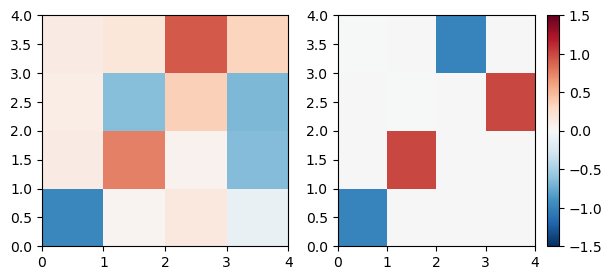

In [7]:
plt.figure(figsize=(7,3))
plt.subplot(1,2,1)
plt.pcolormesh(eigenvectors,vmin=-1.5,vmax=1.5,cmap='RdBu_r')

plt.subplot(1,2,2)
plt.pcolormesh(rot_eigenvectors,vmin=-1.5,vmax=1.5,cmap='RdBu_r')

plt.colorbar()

In [8]:
# Download data from https://downloads.psl.noaa.gov/Datasets/noaa.oisst.v2/new/ 
# select file sst.oisst.mon.mean.1982.nc

fnom = xr.open_dataset('sst.oisst.mon.mean.1982.nc',decode_times=False)
fnom


<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, time: 499)
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * time     (time) float64 6.647e+04 6.65e+04 6.653e+04 ... 8.16e+04 8.163e+04
Data variables:
    sst      (time, lat, lon) float32 ...
Attributes:
    CDI:            Climate Data Interface version 1.9.10 (https://mpimet.mpg...
    source:         NOAA/NCEI https://www.ncei.noaa.gov/data/sea-surface-temp...
    institution:    NOAA/National Centers for Environmental Information
    Conventions:    CF-1.5
    title:          NOAA/NCEI 1/4 Degree Daily Optimum Interpolation Sea Surf...
    References:     https://www.psl.noaa.gov/data/gridded/data.noaa.oisst.v2....
    dataset_title:  NOAA Daily Optimum Interpolation Sea Surface Temperature
    version:        Version 2.1
    comment:        Reynolds, et al.(2007) Daily High-Resolution-Blended Anal...
    CDO:            Climate Data Operators version 1.9.10 (https://mpimet.mpg...
    history:        Tue Aug  8 15:12:26 2023: ncks -d time,4, /scratch/csmith...
    NCO:            netCDF Operators version 4.8.1 (Homepage = http://nco.sf....

In [9]:
ax_y = pd.date_range('1982-01-01','2022-12-31',freq='M')
lon2d,lat2d = np.meshgrid(fnom.lon.values,fnom.lat.values)


In [10]:
sst = fnom.sst.values[0:492]
tsteps, nlat, nlon = np.int16(sst.shape)
nyear = np.int16(tsteps/12)
print(nyear,tsteps,nlat,nlon)

41 492 180 360


# remove monthly climatolgy 

(12, 180, 360)
(492, 180, 360)


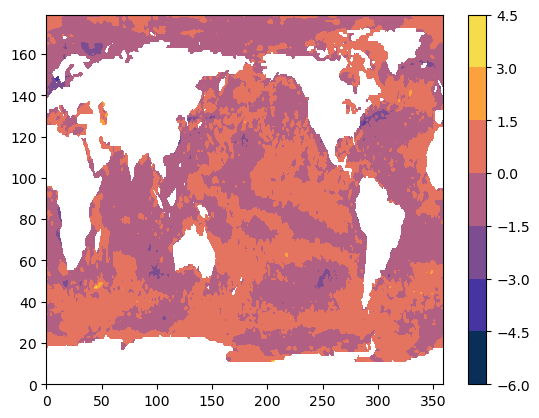

In [11]:
# monthly anomalies

#monthly climatology
sst_mon_clim = fnom.sst.values[0:492,:,:].reshape(41,12,nlat,nlon).mean(axis=0)
print(sst_mon_clim.shape)


# get monthly anomalies

sst_anom = (sst.reshape([nyear,12,nlat,nlon]) - sst_mon_clim).reshape(nyear*12,nlat,nlon)
print(sst_anom.shape)
plt.figure()
plt.contourf(sst_anom[0],cmap=cm.cm.thermal)
plt.colorbar()


#  using xEOFs library for EOF and rotated EOF analysis

In [14]:
sst_ds = xr.Dataset(coords={'lat': fnom.lat.values, 'lon': fnom.lon.values,'time': fnom.time.values[0:492]},data_vars={'ssta': (('time','lat','lon'),sst_anom )})
sst_ds

<xarray.Dataset>
Dimensions:  (time: 492, lat: 180, lon: 360)
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * time     (time) float64 6.647e+04 6.65e+04 6.653e+04 ... 8.139e+04 8.142e+04
Data variables:
    ssta     (time, lat, lon) float32 nan nan nan ... 0.03182 0.01879 0.01863

In [15]:
model = xe.models.EOF(n_modes=10)
model.fit(sst_ds.ssta,dim='time')
scores = model.scores()
print(100*model.explained_variance_ratio().data)

[14.63793316  9.07762709  3.76067484  2.5194681   2.36603771  2.1402109
  1.97915355  1.79745634  1.6023443   1.50085674]


In [16]:
components = model.components()
#components

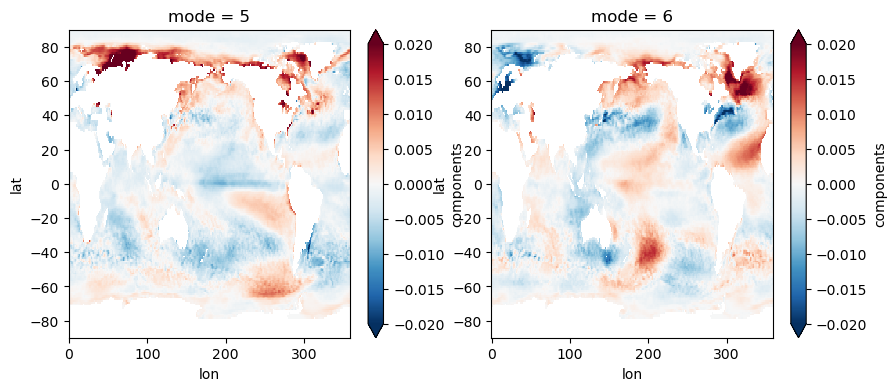

In [17]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
components.sel(mode=5).plot(vmin=-.02,vmax=.02,cmap='RdBu_r')
plt.subplot(1,2,2)
(-1.*components).sel(mode=6).plot(vmin=-.02,vmax=.02,cmap='RdBu_r')


# Rotated EOFs

In [18]:
#model = xe.models.EOF(n_modes=10)
#model.fit(data)
rotator = xe.models.EOFRotator(n_modes=10)
rotator.fit(model)
rot_components = rotator.components()

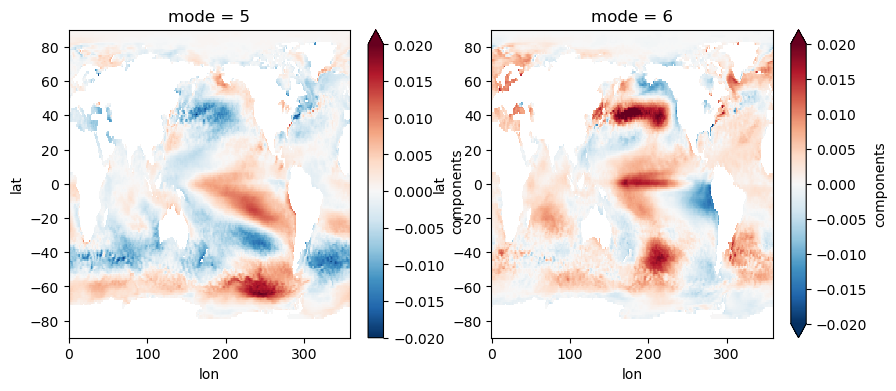

In [19]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
rot_components.sel(mode=5).plot(vmin=-.02,vmax=.02,cmap='RdBu_r')
plt.subplot(1,2,2)
rot_components.sel(mode=6).plot(vmin=-.02,vmax=.02,cmap='RdBu_r')
